<span style="font-size:250%">Repo Analysis History</span>

This is the historical section of the [RepoAnalysis](./RepoAnalysis.ipynb) notebook, which is aimed at developing the methodology to analyze a given set of repositories fast.
This notebook includes many of the early approaches and insights of repository analysis. It acts supplementary to the [RepoAnalysis](./RepoAnalysis.ipynb) notebook, which starts at the first big run of the analysis.

This notebook is structured as follows: At the beginning, [initial approaches](#Initial-approaches) are described. This especially includes evaluating srcML as analysis tool. In the end, regex is decided as way to go. Following, the insights are aggregated into a [first working](#working) (with acceptable time) set of functions to analyze one or multiple repos. Going on from this, an approach for [mapping from users](#mapuser) to their impact with dictionaries and chainmaps is developed (but later discarded). 


In [2]:
import os
import numpy as numpy
import matplotlib.pyplot as pyplot
from git import Repo 
from datetime import datetime
import matplotlib as matplotlib
import subprocess
import time
from git.db import GitCmdObjectDB
from git.db import GitDB

# Initial approaches
In my initial approaches, I explored the gitpython an srcml technologies, the first to iterate over commits and get their contents, and the second to analyze the contents.
I used the [Scylla](https://github.com/bptlab/scylla/) repo for testing purposes, as it was neither too big, nor too small.

For this cell to work, the repo has to be checked out beforehand, e.g. with 
`Repo.clone_from(url='https://github.com/bptlab/scylla.git', to_path='scylla.git', bare=True)`

In [20]:
repo = Repo.init('scylla.git', bare=True, odbt=GitDB)

## Exploring gipython and srcml

### Gitpython Classes over time
The first gitpython approach already allows to iterate over files of all commits. I used this to implement a simple classes over time metric

Time used: 10.006792783737183


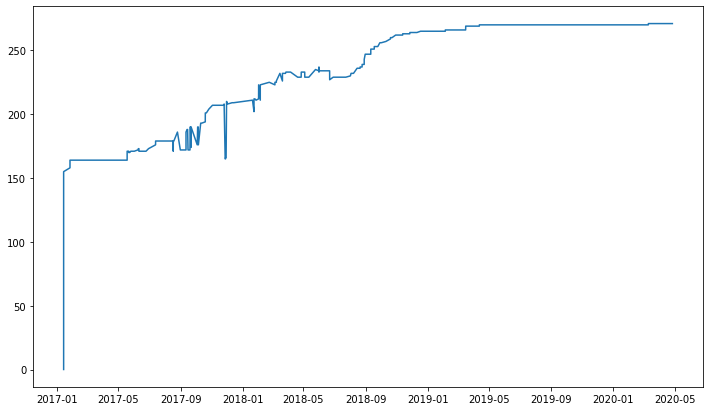

In [12]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            fileCount = fileCount + 1
    fileCounts.append(fileCount)
end = time.time()
print('Time used: '+str(end - start))
    
dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

### Gitpython Test classes over time
With the same approach, also a heutistic about test classes was possible

Time used: 2.4306929111480713


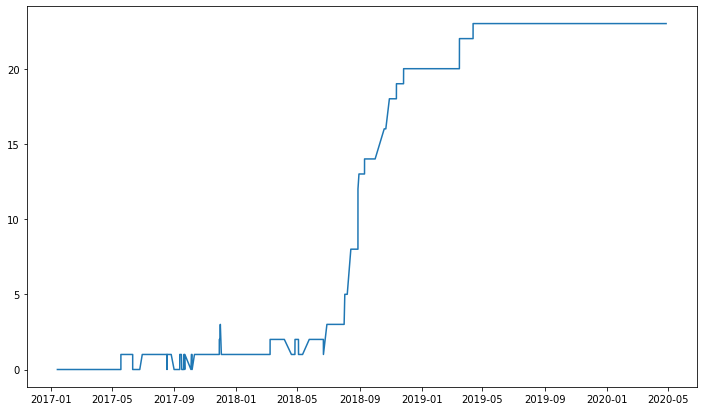

In [4]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java') and ('Test' in obj.name):
            fileCount = fileCount + 1
    fileCounts.append(fileCount)
end = time.time()
print('Time used: '+str(end - start))

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

### Analyze the srcml contents of a single file
In the following, I started to explore scrml: From testing in the console, I knew that the following command worked: <br>
``` git --git-dir="./scylla.git" show ee00a205a2225ad73b0264cf7ba64be5c7044d0b:src/main/java/de/hpi/bpt/scylla/Scylla.java | xargs -0 srcml -l Java --text ```

In [13]:
commit = repo.active_branch.commit
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java') and obj.name == 'Scylla.java':
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        print(content)

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<unit xmlns="http://www.srcML.org/srcML/src" revision="0.9.5" language="Java"><package>package <name><name>de</name><operator>.</operator><name>hpi</name><operator>.</operator><name>bpt</name><operator>.</operator><name>scylla</name></name>;</package>

<import>import <name><name>java</name><operator>.</operator><name>util</name><operator>.</operator><name>Arrays</name></name>;</import>

<comment type="block" format="javadoc">/**
 * Scylla is an extensible simulator for business processes in BPMN. &lt;br&gt;
 * This class initializes and runs the {@link SimulationManager} which simulates the processes based on the given input.
 * 
 * @author Tsun Yin Wong
 *
 */</comment>
<class><specifier>public</specifier> class <name>Scylla</name> <block>{
    <decl_stmt><decl><specifier>public</specifier> <specifier>static</specifier> <type><specifier>final</specifier> <name>String</name></type> <name>OS</name> <init>= <expr><call><name><name>S

With srcml I could for instance extract all functions and then analyze their length:

In [16]:
content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, 'src/main/java/de/hpi/bpt/scylla/Scylla.java'), shell=True)
tree = etree.fromstring(content)
functions = tree.xpath('//src:function', namespaces=namespaces)
for x in list(map(lambda func: etree.tostring(func).decode('utf-8'), functions)):
    print('')
    print(x)
print(list(map(lambda func: len(etree.tostring(func).decode('utf-8').split('\n')), functions)))
metric = 0
print('Scylla.java: '+str(metric))


<function xmlns="http://www.srcML.org/srcML/src"><specifier>public</specifier> <specifier>static</specifier> <type><name>void</name></type> <name>main</name><parameter_list>(<parameter><decl><type><name><name>String</name><index>[]</index></name></type> <name>args</name></decl></parameter>)</parameter_list> <throws>throws <argument><expr><name>IllegalArgumentException</name></expr></argument></throws> <block>{

        <if>if <condition>(<expr><call><name><name>Arrays</name><operator>.</operator><name>stream</name></name><argument_list>(<argument><expr><name>args</name></expr></argument>)</argument_list></call><operator>.</operator><call><name>anyMatch</name><argument_list>(<argument><expr><lambda><parameter_list type="pseudo"><parameter><decl><name>x</name></decl></parameter></parameter_list> -&gt; <block type="pseudo"><expr><call><name><name>x</name><operator>.</operator><name>contains</name></name><argument_list>(<argument><expr><literal type="string">"--help"</literal></expr></arg

### Analyze the srcml contents of all files of a commit

This could also be done fore each file of a commit:

In [14]:
import subprocess
from lxml import etree

repo = Repo.init('./scylla.git', bare=True, odbt=GitDB)
commit = repo.active_branch.commit
namespaces = {'src': 'http://www.srcML.org/srcML/src'}

start = time.time()
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True)
        tree = etree.fromstring(content)
        functions = tree.xpath('//src:function/src:block', namespaces=namespaces)
        linesPerFunction = list(map(lambda func: len(etree.tostring(func).decode('utf-8').split('\n')), functions))
        print(linesPerFunction)
        metric = sum(linesPerFunction) / len(linesPerFunction) if len(linesPerFunction) > 0 else 0
        print(obj.name+': '+str(metric))
end = time.time()
print('Time used: '+str(end - start))

[6, 5, 7]
Scylla.java: 6.0
[20, 45, 14, 10]
ScyllaScripts.java: 22.25
[94, 25, 12, 24, 13, 5, 3, 3, 3, 3, 3]
SimulationManager.java: 17.09090909090909
[5, 28, 3, 3, 3, 3, 3]
FocusTraversalOnArray.java: 6.857142857142857
[4, 4, 6, 3, 3, 3, 11]
ArgumentTests.java: 4.857142857142857
[3, 10]
SeedProvider.java: 6.5
[4, 4, 4, 5, 3]
SimulationManagerForTests.java: 4.0
[6, 4, 3, 4, 3, 3, 3, 3, 3, 3, 9, 4, 9, 9, 1, 3, 3, 10]
SimulationTest.java: 4.611111111111111
[]
TestSeeds.java: 0
[10, 7, 16, 3, 9, 8, 9, 9, 9]
TestUtils.java: 8.88888888888889
[3]
TravisTests.java: 3.0
[13, 7, 6, 3, 6, 4, 4]
CheckBoxList.java: 6.142857142857143
[3, 3, 3, 4]
CheckboxListPanel.java: 3.25
[9, 9, 3, 3, 3, 3]
Console.java: 5.0
[5, 3, 3, 3, 3, 5, 3, 26, 3, 3, 3, 3, 8, 5, 37, 18, 28, 7, 9, 4, 8, 3, 6, 3, 5, 18, 6, 4, 3, 6, 4, 3]
EditorPane.java: 7.75
[9, 3, 7]
EditorTabTitlePanel.java: 6.333333333333333
[3, 14, 11, 9, 9]
ExpandPanel.java: 9.2
[10, 10, 5, 14, 5]
ExtendedListChooserPanel.java: 8.8
[]
FormManager.java:

## Combine gitpython and srcml

After knowing what both technologies could do, I combined them:

### Naive approach to calculate LoC over time

(Note: When recycling the notebook, the following cell was not reevaluated because of the long run time)

In [15]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
lineCounts = []

start = time.time()
for commit in repo.iter_commits():
    lineCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
            lineCount = lineCount + len(content.split('\n'))
    lineCounts.append(lineCount)

end = time.time()
print('Time used: '+str(end - start))

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, lineCounts, '-')

KeyboardInterrupt: 

### And now for average LoC per File:

In [ ]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
lineCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    lineCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 -I $ srcml -l Java --text $ | wc -l' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
            lineCount = lineCount + int(content)
            fileCount = fileCount + 1
    if fileCount == 0:
        lineCounts.append(0)
    else:
        lineCounts.append(lineCount / fileCount)

end = time.time()

Time used: 7572.929245471954


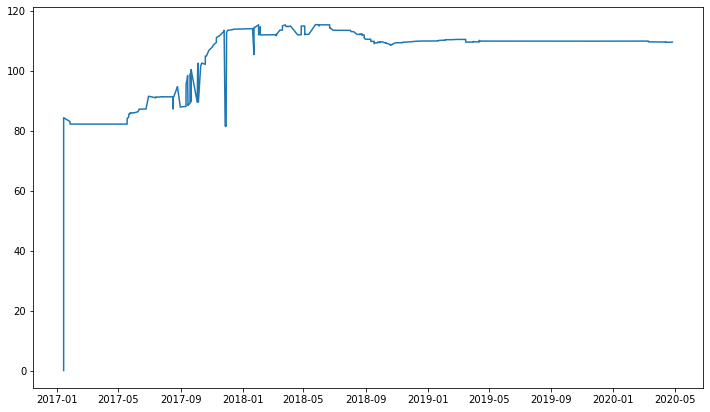

In [52]:
print('Time used: '+str(end - start))
dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, lineCounts, '-')

## Tuning file traversal speed
While the initial srcml approach works, it is incredibly slow. 2h for one not even big repository just is not feasible.

Through testing I found some general remarks:
* Calculating LoC for one single commit takes already very long!
* Removing the xargs to srcml does not change time significally
* Checking out improves time; but not enough that I would accept
* Using gitpython only to access file contents offers orders of magnitude of improvement and should therefore be further pursued

The following cells show different the approaches I tried to tune the speed and which lead me to this conclusions. <br>

### ScrMl approach
The previous appraoch: 27 seconds for one commit (note: when reevaluating the cells for submission, times were much higher, but still comparable)

In [25]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        lineCount = lineCount + len(content.split('\n'))
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29976
Time used: 102.27309346199036


### Using wc
`wc` can be used to get the lines of some output. Maybe this reduces the output that python needs to read from shell? <br>
No, it still takes 27 seconds

In [26]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 -I $ srcml -l Java --text $ | wc -l' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        lineCount = lineCount + int(content)
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29705
Time used: 101.1365864276886


### Checkout repos
Or let's try checkouted repos ...<br>
While checkouted repositories are indeed faster, it is not the order of magnitude that we need

In [24]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla/.git" show %s:%s | wc -l' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        lineCount = lineCount + int(content)
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29152
Time used: 65.3673300743103


### Using pipes
Using Toni's first tip (pipes):<br>
Is a little bit faster but again not fast enough

In [27]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        with subprocess.Popen(['srcml', '-l', 'Java'], stdin=subprocess.PIPE, stdout=subprocess.PIPE) as srcml:
            srcml.stdin.write(obj.data_stream.read())
            srcml.stdin.close() 
            content = srcml.stdout.read().decode("utf-8")
        lineCount = lineCount + len(content.split('\n'))
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29967
Time used: 87.47958111763


### Using GitPython only
Using Toni's second tip (gitpyhon `blob.data_stream`):<br>
This is two orders of magnitude faster! Thanks a lot!

In [28]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = obj.data_stream.read().decode("utf-8")
        lineCount = lineCount + len(content.split('\n'))
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29423
Time used: 0.4099154472351074


It is even so fast, we can analyze the whole repo faster than a single commit with the old way 

Time used: 84.62123703956604


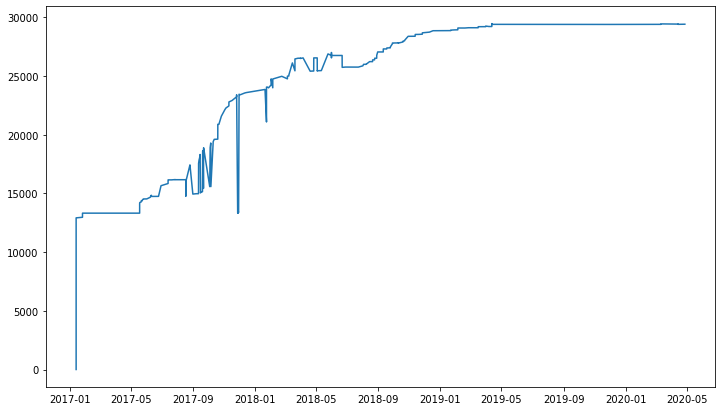

In [29]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
lineCounts = []

start = time.time()
for commit in repo.iter_commits():
    lineCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            content = obj.data_stream.read().decode("utf-8")
            lineCount = lineCount + len(content.split('\n'))
    lineCounts.append(lineCount)

end = time.time()
print('Time used: '+str(end - start))

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, lineCounts, '-')

## Replacing ScrML: LoC/Method With Regex 

The preceding chapter has shown that calling a subprocess for every commit is completely unfeasible. 
This means that scrml cannot be used to analyze the repositories fast.

Therefore, an alternative has to be found: Regex, which can work very fast and very precise on the file contents provided by gitpython.
The following function shows how regex can be used to analyze the lines of code per method for a repository.

Time used: 184.47402715682983


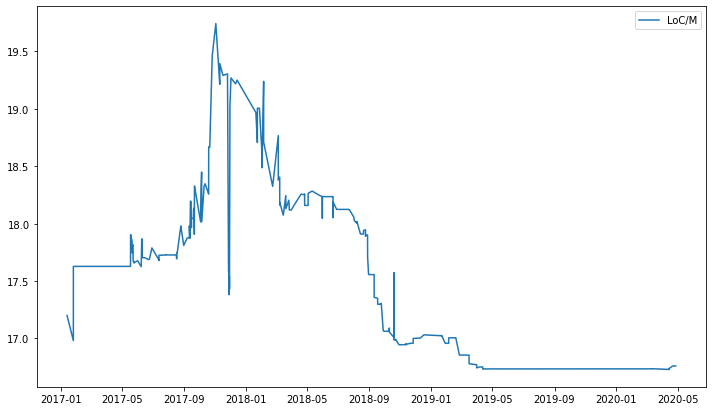

In [30]:
import re
commit = repo.active_branch.commit
classRegex = re.compile(r"class")
methodRegex = re.compile(r"(public|protected|private|static|\s) +[\w\<\>\[\]]+\s+(\w+) *\([^\)]*\) *(\{?|[^;])")

timestamps = []
metrics = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    aggregatedMetric = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            fileCount = fileCount + 1
            contentWithHeader = obj.data_stream.read().decode("utf-8")
            content = contentWithHeader.split('{', 1)[1]
            numMethods = len(methodRegex.findall(content))
            loc = len(content.split('\n'))
            metric = loc / numMethods if numMethods > 0 else 0
            aggregatedMetric = aggregatedMetric + metric
    metrics.append(aggregatedMetric/fileCount if fileCount > 0 else 0)
    timestamps.append(datetime.fromtimestamp(commit.committed_date))

end = time.time()
print('Time used: '+str(end - start))

metrics.pop()
timestamps.pop()

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, metrics, '-')
pyplot.legend(['LoC/M'])

---
New chapter

---

In [2]:
import re
import matplotlib.pyplot as pyplot
import matplotlib
import time
from datetime import datetime
from multiprocessing import Pool
import multiprocessing
import functools

In [3]:
%load_ext autoreload
%aimport repoLibrarian
%aimport repoAnalysis
%autoreload

<a class="anchor" id="working"></a>

# Developing a first approach to analyze a given set of repos

Now that analyzing repositories was generally possible, a suitable approach to do this on a large scale for multiple repositories and multiple metrics had to be developed.

The following steps use the [repoLibrarian.py](./repoLibrarian.py) module for managing the set of analyzed repos. For more information on the module see its source code or the [RepoLibrarian.ipynb](./RepoLibrarian.ipynb) notebook. The development of said module has been heavily influenced by this notebook, and was once even included in this notebook before RepoLibrarian was split apart. While there were many iterations and steps that lead to the [repoAnalysis.py](./repoAnalysis.py) module of today, iterations were usally by in-cell-edits, therefore not all of history could be restory. However, the following cells show the first steps toawrd efficient mechanisms.

A local folder of repositories is used at first, to test the developed approaches in a safe environment. Most of the used repositories are listed below.

In [63]:
repoLibrarian.setReposFolder('./repos/')

'./repos/'

In [8]:
list(repoLibrarian.knownRepos())

['json-iterator/java.git',
 'alibaba/arthas.git',
 'sayems/jbehave-tutorial.git',
 'bptlab/Unicorn.git',
 'bptlab/correlation-analysis.git',
 'bptlab/scylla.git',
 'bptlab/cepta.git',
 'bptlab/fcm2cpn.git']

In [9]:
repoLibrarian.deleteRepo('sayems', 'jbehave-tutorial.git')

Deleted repo "sayems/jbehave-tutorial.git"


## Aggregated Knowledge (the intermediate state)

The following function aggregates the knowledge from the previous chapters. It runs a function for all files of all commits of a repo, aggregates for each commit and combines with the counted files. Notice the commented lines that remove the first metric values that are zero. This was meant to filter out outliers at the start of projects (when there is usually just a readme) but the idea was later discarded as it was unsure what a metric value of zero would mean generally for all metrics. The `fileCountConsumer` parameter was later, as there were metrics where the aggregation of all files was not to average, but rather to sum. CP437 decoding instead of utf-8 is needed as there are some asian repositories in the set which break the utf-8.

Variations/iterations of this functions can be found in the course of this notebook and the final functions in [repoAnalysis.py](./repoAnalysis.py) used for the experiment runs (e.g. the final `calculateDeltaMetrics`) are in the end based on this function.

Note: This function was once also located in the [repoAnalysis.py](./repoAnalysis.py) module, but has been moved back to the notebook to collect historical information in the notebooks and keep the modules cleaner.

In [10]:
def timedMetricPerFileForRepo(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = repoLibrarian.getRepo(user, project)
    timestamps = []
    metrics = []
    try:
        start = time.time()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            for obj in commit.tree.traverse():
                if obj.type == 'blob' and obj.name.endswith('.java'):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    metric = metricFunction(content)
                    aggregatedMetric = aggregatedMetric + metric
            metrics.append(fileCountConsumer(aggregatedMetric, fileCount))
            timestamps.append(commit.committed_date)

        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
#        while len(metrics) > 0 and metrics[-1] < 1:
#            metrics.pop()
#            timestamps.pop()
        return (timestamps, metrics)
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
        return ([],[])

`simpleRunMetric` was the first function to calculate (and display) metrics for multiple repos. Again the base structure of parallely mapping each repo with a metric suite can be found throughout the following course of the project.

In [19]:
def simpleRunMetric(metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    repos = list(map(lambda repo: (repo.split('/', 1)[0], repo.split('/', 1)[1]), repoLibrarian.knownRepos()))

    start = time.time()
    with Pool(int(multiprocessing.cpu_count())) as pool:
        allMetrics = pool.map(functools.partial(timedMetricPerFileForRepo, metricFunction=metricFunction, fileCountConsumer=fileCountConsumer), repos)
    end = time.time()
    print('Total Time used: '+str(end - start))
    
    pyplot.figure(figsize=(12, 7))
    for (timestamps, metrics) in allMetrics:
        dates = matplotlib.dates.epoch2num(timestamps)
        pyplot.plot_date(dates, metrics, '-')
    pyplot.legend(repos)

## Reconstructed historical metric functions

Over the course of the following sections, basic metrics functions had been developed. These were however extracted to the [repoAnalysis.py](./repoAnalysis.py) module and revised over and over so the original implementations are not there anymore (while there are definitely strong traces in the module). Therefore I extracted the historical functions from the git history, so the following cells will run. 

The functions presented basically use the knowledge about using regex that has been shown before. Note the two regexes that are used for lines of code per method and lambda density: Methods are discovered by their method definition (which can be quite diverse in Java). Lambdas are counted when using the `::` or `->` operator. This is more limited, as it does not count usages of function objects when they come from a library or framework are from a class that implements (not extends) a functional interface. However, static type checking is way out of scope of this project.

In [12]:
def safeDivision(a,b):
    return a/b if b > 0 else 0

def removeHeader(contentWithHeader):
    content = contentWithHeader.split('{', 1)
    content = content[1] if len(content) > 1 else ''
    return content

def occurencesOf(regex, content):
    return len(regex.findall(content))

methodRegex = re.compile(r"(public|protected|private|static|\s) +[\w\<\>\[\]]+\s+(\w+) *\([^\)]*\) *(\{?|[^;])")
def locmOf(contentWithHeader):
    content = removeHeader(contentWithHeader)
    numMethods = occurencesOf(methodRegex, content)
    loc = len(content.split('\n'))
    locm = safeDivision(loc, numMethods)
    return locm

lambdaRegex = re.compile(r"->|::")
def lambdaDensity(content):
    numLambdas = occurencesOf(lambdaRegex, content) * 1000
    loc = len(content.split('\n'))
    density = numLambdas / loc
    return density

def loc(content):
    return len(content.split('\n'))

def identity(x,*y):
    return x

## Exploratory runs

To gain an understanding of the (new layer of) data, I ran the metrics on a small test set of repos. There were some insights derived from this:
- Repos tend to have an initial phase where metric deviate strongly from their "usual" flow

Time used for ('bptlab', 'fcm2cpn.git'): 0.4013631343841553
Time used for ('bptlab', 'correlation-analysis.git'): 3.382075071334839
Time used for ('bptlab', 'scylla.git'): 28.26970410346985
Time used for ('json-iterator', 'java.git'): 29.891782999038696
Time used for ('bptlab', 'cepta.git'): 33.18532967567444
Time used for ('bptlab', 'Unicorn.git'): 38.575215578079224
Time used for ('alibaba', 'arthas.git'): 160.6042914390564
Total Time used: 163.90643429756165


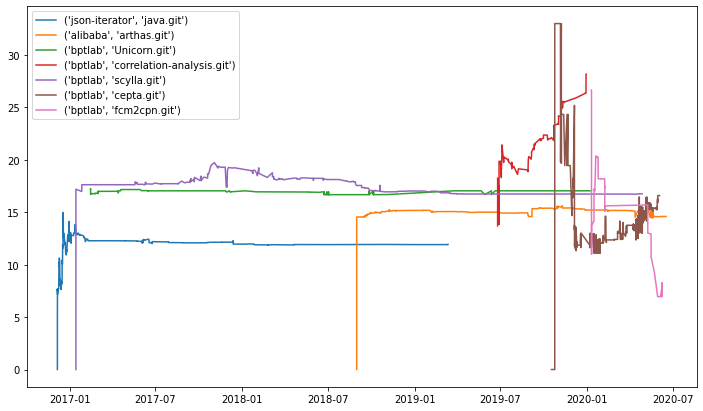

In [20]:
simpleRunMetric(locmOf)

Time used for ('bptlab', 'fcm2cpn.git'): 0.32689738273620605
Time used for ('bptlab', 'correlation-analysis.git'): 1.6104001998901367
Time used for ('bptlab', 'scylla.git'): 8.252939701080322
Time used for ('json-iterator', 'java.git'): 8.504035711288452
Time used for ('bptlab', 'cepta.git'): 21.032324075698853
Time used for ('bptlab', 'Unicorn.git'): 21.757805824279785
Time used for ('alibaba', 'arthas.git'): 44.89477014541626
Total Time used: 48.273399353027344


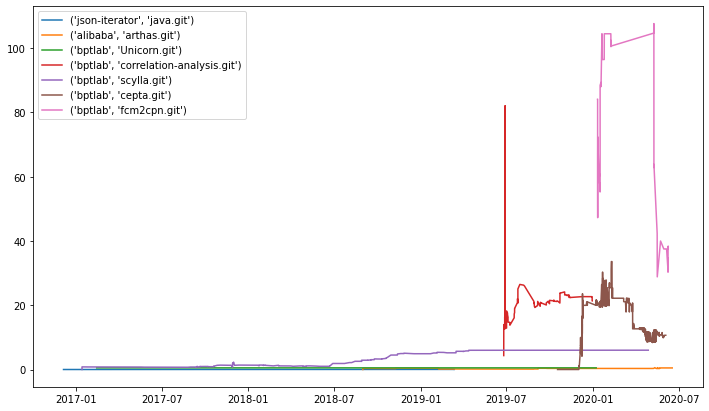

In [21]:
simpleRunMetric(lambdaDensity)

Note: The following metric run is special in multiple aspects: Firstly, the run uses the loc metric, which does not aggregate files by taking the average.
Secondly, it runs on a special set of repositories that were determined by the very first set of polyglots (see [DataExplorer](./DataExplorer.ipynb) for information on how polyglots are determined). This is relevant because it showed how different the method at that point in time performed in different repos: Some runs took under a second, some took nearly 45min. It also showed the large difference in size that could occur which makes repos harder to compare - an insight which strengthend the ideas of calculating metrics diff based and plotting them over lifetime.

The cell has been taken as is (and not reevaluated) as the results are hard to reproduce. However, the list of analyzed repos can be found in the outputs so it is theoretically possible.

Time used for ('Elena-Zhao', 'Guimi.git'): 0.1284182071685791
Time used for ('Elena-Zhao', 'Mini-Chatter.git'): 0.10931038856506348
Time used for ('pleonex', 'ChatRMI.git'): 0.1066889762878418
Time used for ('craigslist206', 'huffman.git'): 0.16383004188537598
Time used for ('Elena-Zhao', 'Weibao.git'): 0.24792146682739258
Time used for ('pleonex', 'CocoKiller.git'): 0.2406604290008545
Time used for ('miken22', '304-Project.git'): 0.24741840362548828
Time used for ('bptlab', 'fcm2cpn.git'): 0.2866392135620117
Time used for ('pleonex', 'NiKate-Origins.git'): 0.39778637886047363
Time used for ('JTReed', 'Porygon.git'): 0.21101975440979004
Failed to analyze ('braliar', 'jabref.git'): Reference at 'refs/heads/master' does not exist
Time used for ('tyler124', 'Monitordroid.git'): 0.23861050605773926
Time used for ('GourdErwa', 'jasper_sample.git'): 0.2540762424468994
Time used for ('JTReed', 'Porygon2.git'): 0.4825553894042969
Time used for ('shengnwen', 'WeiBaoSSE.git'): 0.5534257888793945

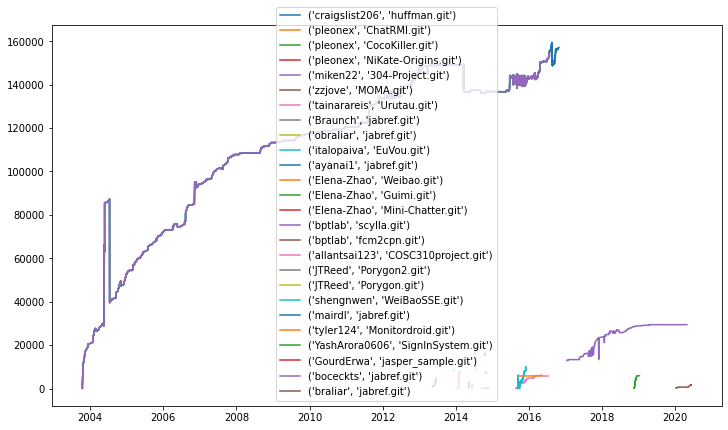

In [62]:
simpleRunMetric(loc, identity)

Another insight from the first "real repository set" run was that there are forks which have duplicate data. At that time, the problem was solved by deleting all duplicates except the newest. However, the mechanism has not been generalized as forks could not only be advancements of their source, but also be parallely developed. Instead, later, when evaluating the results, duplicates are eliminated by taking distinct commit shas.

In [10]:
# Delete all the duplicates except the newest
for (user, repo) in repoLibrarian.managedRepos():
    if repo.endswith('jabref.git') and not 'mairdl' in user:
        deleteRepo(user, repo)

<a class="anchor" id="mapuser"></a>

# Exploring approaches to map from user commits to metrics

As the focus of the project was to analyze developer code, not repositories, the analysis results need to be attributed to developers. In the following cells, I evaluated some approaches to do so. <br>
Note: Again, these are only the that could be reconstructed, many approaches have been tried and discard immediately.

### For each project: map from commit sha to metrics 

The first problem to solve is to calculate metric deltas of commits to their parents instead of just looking at the project metrics at a given commit.<br>
The following approach uses an ordered dict of commit hexsha to commit data tuple to allow this: As each commit saves the hexsha of its parent, this can later be resolved. The `Wrap` class wraps the dict because of weird behavior with `Pool.map` (some data types cannot be pickled and thus must be wrapped, OrderedDict is one of them).

Apart from this changes, `averageMetricPerCommitForRepo` is a direct successor to the `timedMetricPerFileForRepo` from above. The function has been steadily improved, the following cell shows a progressed version that has been adapted to run in this "history" context.

In [30]:
import collections

class Wrap:
    def __init__(self, data):
        self.data = data

def averageMetricPerCommitForRepo(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = repoLibrarian.getRepo(user, project)
    try:
        start = time.time()
        commitToMetric = collections.OrderedDict()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            totalLoc = 0
            for obj in commit.tree.traverse():
                if repoLibrarian.isJavaFile(obj):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    loc = repoAnalysis.loc(content)
                    metric = metricFunction(content) #, loc=loc) Named parameters have been introduced later when metric functions were upgraded, removed in revision for compliance to the old code
                    aggregatedMetric = aggregatedMetric + metric
                    totalLoc = totalLoc + loc
            consumedMetric = fileCountConsumer(aggregatedMetric, fileCount)
            parent = commit.parents[-1].hexsha if len(commit.parents) == 1 else None
            commitToMetric[commit.hexsha] = (commit.committed_date, consumedMetric, parent, totalLoc)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
    return Wrap(commitToMetric)

### Calculate deltas of commits to parents

The map can then be used to determine for each commit the delta to it's parent commit:

In [23]:
def deltasOf(metricPerCommit):
    deltas = collections.OrderedDict()
    for (sha, metric) in metricPerCommit.items():
        if(metric[2] != None): #There is a unique parent -> No merges or orphans(initial commit)
            parentMetric = metricPerCommit[metric[2]]
            deltas[sha] = (metric[0], (metric[1] - parentMetric[1]), metric[2])
    return deltas

To see that the delta function works, I applied it to my favourite example repository. I also extracted the function for plotting repos for this purpose.

In [131]:
data = averageMetricPerCommitForRepo(('bptlab', 'scylla'), locmOf).data

Time used for ('bptlab', 'scylla'): 28.080988883972168


In [32]:
def plotByDate(data):
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    dates = matplotlib.dates.epoch2num(list(timestamps))
    pyplot.plot_date(dates, list(metrics), '-')

Plotting the data shows that it looks sane. Note that the deltas do not 100% match the absolute changes, this is due to the fact that many of the bigger deflections result from merges where there is no delta value present; one could also say that  the continuity of the graphs is misleading here.

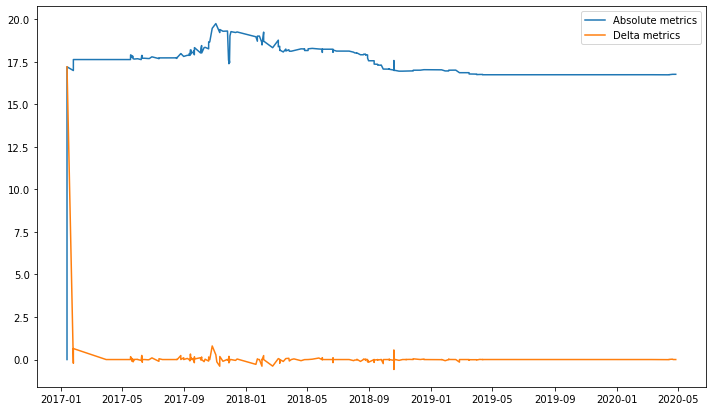

In [132]:
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data.values())
plotByDate(deltas.values())
pyplot.legend(['Absolute metrics', 'Delta metrics'])

### Plot by lifecycle

An interesting approach to compare repositories (and later developers) using a time component is the lifecycle approach. For this, time of an event is set in relation to the first and last event of a series. This makes is possible to compare curves of repositories/developers that started and ended at completely different dates. When additionally using deltas, it is also possible to quantitatively compate them.

A simple additional plot method has been created to implement this approach:

In [137]:
def plotByLifecycle(data):
    if len(data) <= 1:
        pyplot.plot([], [])
        return
    data = list(sorted(data, key=lambda tupl: -tupl[0]))
    timestamps = map(lambda tupl: tupl[0], data)
    metrics = map(lambda tupl: tupl[1], data)
    maxDate = next(iter(data))[0]
    minDate = next(reversed(data))[0]
    interval = maxDate - minDate
    dates = list(map(lambda stamp : (stamp - minDate) / interval, timestamps))
    pyplot.plot(dates, list(metrics), '-')

To test the sanity of this approach, it has been applied to the example repo. We expect the plot to look exactly like the one above, which it does.

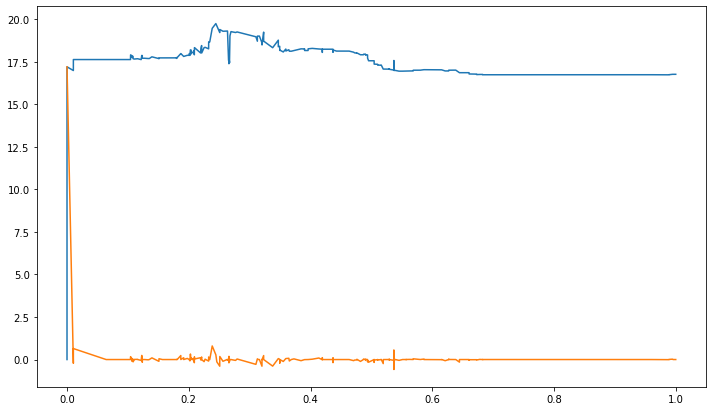

In [138]:
pyplot.figure(figsize=(12, 7))
plotByLifecycle(data.values())
plotByLifecycle(deltas.values())

## Create and analyze basic set of repositories to analyzed

To test developed approaches, a first set of polyglot user repositories (and some more) was selected. "Back then" every 1221th user was selected as base for the polyglot selection (`MOD(id, 1221) = 5`) which lead to 12 polyglots. 

I wanted to see if I could map from a commit sha to metrics even when multiple repositories were analyzed (which is needed as one developer usually works on multiple repositories).

`basicJavaRepos` again is a reconstructed value; I usually switched between the test repo set and the first set of projects of polyglot users.

In [121]:
basicJavaRepos = list(filter(lambda tupl: repoLibrarian.isJavaRepo(*tupl), [
    ('MarioLizana', 'RadioControlSED'),
    ('craigslist206', 'huffman'),
    ('pleonex', 'ChatRMI'),
    ('pleonex', 'CocoKiller'),
    ('pleonex', 'NiKate-Origins'),
    ('pleonex', 'locaviewer'),
    ('miken22', '304-Project'),
    ('NeebalLearningPvtLtd', 'InventoryManagementSystem'),
    ('zzjove', 'MOMA'),
    ('tainarareis', 'Urutau'),
    ('italopaiva', 'EuVou'),
    ('ShutUpPaulo', 'TecProg_2016-01'),
    ('andrevctr12', 'PAA_HUFFMAN'),
    ('Elena-Zhao', 'Weibao'),
    ('Elena-Zhao', 'MOMA'),
    ('Elena-Zhao', 'Database-Auto-troubleshooting'),
    ('Elena-Zhao', 'Guimi'),
    ('Elena-Zhao', 'Mini-Chatter'),
    ('alstonlo', 'Chat-Software-Assignment'),
    ('alstonlo', 'Bongo-Cat-Attacc'),
    ('dataspy', 'surprise-theory'),
    ('ieeeugrsb', 'ieeextreme8'),
    ('bptlab', 'scylla'),
    ('bptlab', 'fcm2cpn'),
    ('allantsai123', 'COSC310project'),
    ('JTReed', 'Porygon2'),
    ('JTReed', 'Porygon'),
    ('shengnwen', 'WeiBaoSSE'),
    ('lucasBrilhante', 'campus-party-mobile'),
    ('lucasBrilhante', 'das-framework-teste'),
    ('mairdl', 'jabref'),
    ('tyler124', 'Monitordroid'),
    ('YashArora0606', 'SignInSystem'),
    ('GourdErwa', 'jasper_sample'),
    ('igorribeiroduarte', 'formulasTesouroDireto')
]))
for x in basicJavaRepos: print(x)

Could not download repo "alstonlo/Chat-Software-Assignment
Failed to download ('alstonlo', 'Chat-Software-Assignment'): Cmd('git') failed due to: exit code(128)
  cmdline: git clone --bare -v https://github.com/alstonlo/Chat-Software-Assignment.git ./repos/alstonlo/Chat-Software-Assignment.git
  stderr: 'Cloning into bare repository './repos/alstonlo/Chat-Software-Assignment.git'...
fatal: could not read Username for 'https://github.com': No such device or address
'
('MarioLizana', 'RadioControlSED')
('craigslist206', 'huffman')
('pleonex', 'ChatRMI')
('pleonex', 'CocoKiller')
('pleonex', 'NiKate-Origins')
('pleonex', 'locaviewer')
('miken22', '304-Project')
('NeebalLearningPvtLtd', 'InventoryManagementSystem')
('zzjove', 'MOMA')
('tainarareis', 'Urutau')
('italopaiva', 'EuVou')
('ShutUpPaulo', 'TecProg_2016-01')
('andrevctr12', 'PAA_HUFFMAN')
('Elena-Zhao', 'Weibao')
('Elena-Zhao', 'MOMA')
('Elena-Zhao', 'Database-Auto-troubleshooting')
('Elena-Zhao', 'Guimi')
('Elena-Zhao', 'Mini-Cha

To deal with the pickling errors of `Pool.map` I tried more ways, such as using ThreadPools instead (this would avoid the functools partial, which is needed because I use lambdas). However I stuck to `Pool.map` for parallelism.

In [122]:
# from multiprocessing.pool import ThreadPool
# import consumers

start = time.time()
with Pool(int(multiprocessing.cpu_count()/4)) as pool:
    #allMetrics = pool.map(lambda repo: averageMetricPerCommitForRepo(repoTuple=repo, metricFunction=locmOf), basicJavaRepos)
    allMetrics = pool.map(functools.partial(averageMetricPerCommitForRepo, metricFunction=locmOf), basicJavaRepos)
allMetrics = list(map(lambda wrap: wrap.data, allMetrics))
end = time.time()
print('Total Time used: '+str(end - start))

Time used for ('Elena-Zhao', 'Database-Auto-troubleshooting'): 0.3693199157714844
Time used for ('MarioLizana', 'RadioControlSED'): 0.3744783401489258
Time used for ('pleonex', 'ChatRMI'): 0.4095268249511719
Time used for ('Elena-Zhao', 'MOMA'): 0.41657161712646484
Time used for ('craigslist206', 'huffman'): 0.4591677188873291
Time used for ('miken22', '304-Project'): 0.48020148277282715
Time used for ('andrevctr12', 'PAA_HUFFMAN'): 0.46935009956359863
Time used for ('pleonex', 'CocoKiller'): 0.5340681076049805
Time used for ('Elena-Zhao', 'Weibao'): 0.6766207218170166
Time used for ('Elena-Zhao', 'Mini-Chatter'): 0.3139381408691406
Time used for ('pleonex', 'NiKate-Origins'): 0.8306424617767334
Time used for ('Elena-Zhao', 'Guimi'): 0.36624956130981445
Time used for ('NeebalLearningPvtLtd', 'InventoryManagementSystem'): 1.0844483375549316
Time used for ('ieeeugrsb', 'ieeextreme8'): 0.5296401977539062
Time used for ('bptlab', 'fcm2cpn'): 0.5534877777099609
Time used for ('JTReed', 'Por

Plotting the data we can see that there seems to be a "habitable zone" for loc per method (between approx. 5 and 20), where many repos lie. The number of repos more or less encourages this assumption.

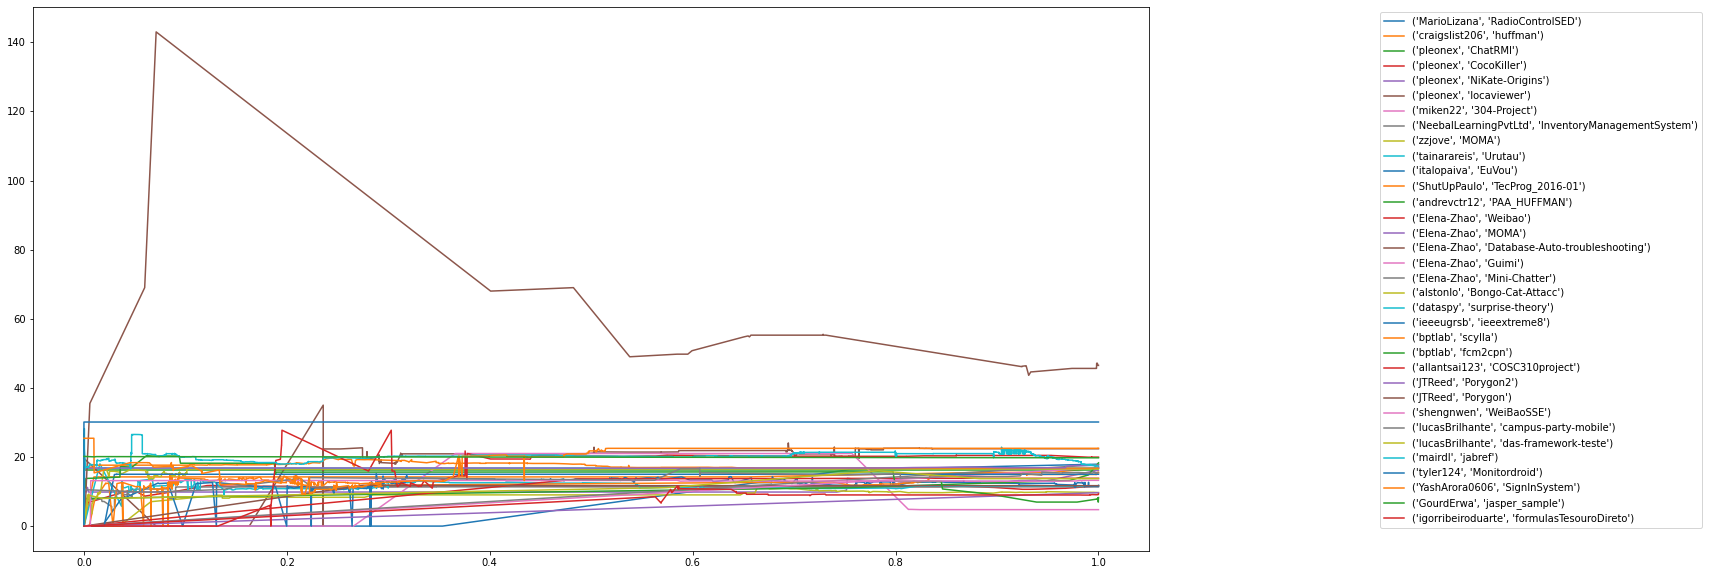

In [140]:
# reposToMetrics = dict(zip(repos, allMetrics))

pyplot.figure(figsize=(20, 10))
for data in allMetrics:
    plotByLifecycle(
        #deltasOf(
            data.values()
        #)
    )

pyplot.legend(basicJavaRepos, bbox_to_anchor=(1.5, 1.0))

Plotting deltas does not lead to any significant insights, except that looks like for most repos deltas are more extreme at the beginning (which is natural, as the influence of one commit on the overall code base is higher)

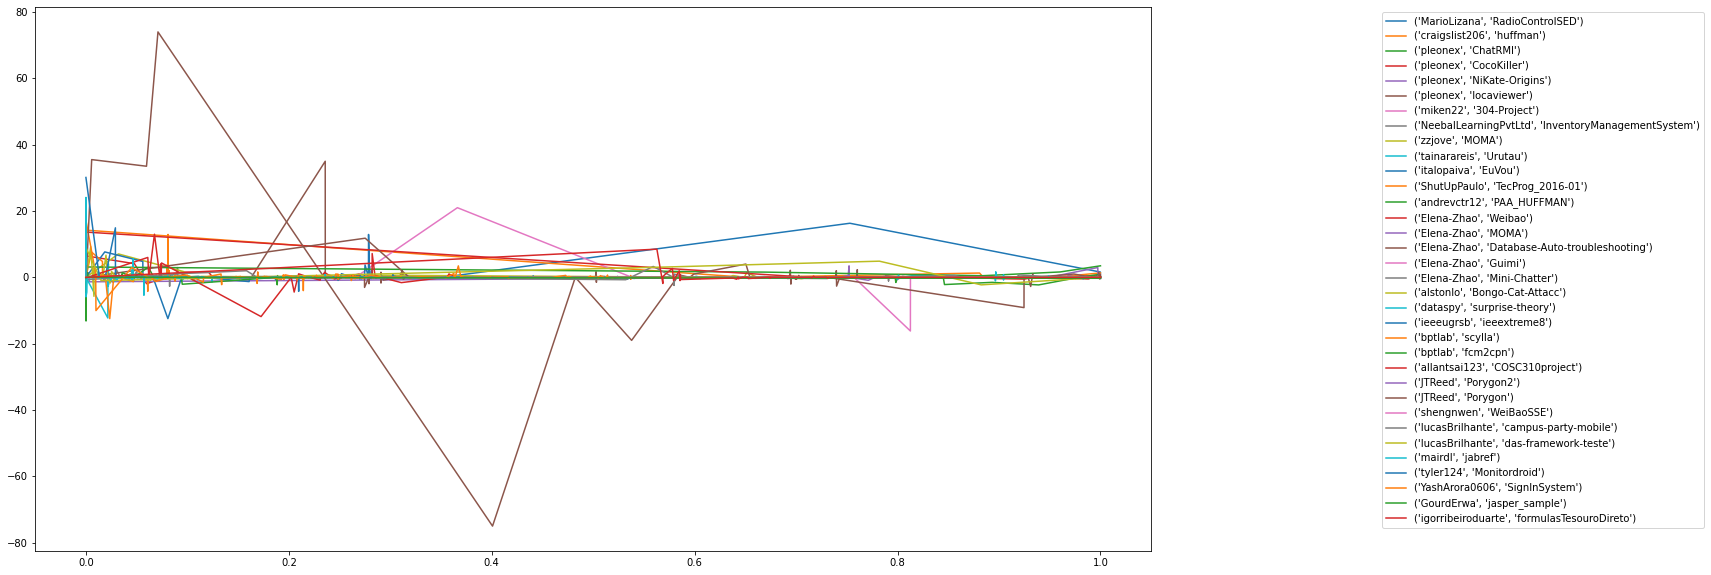

In [142]:
pyplot.figure(figsize=(20, 10))
for data in allMetrics:
    plotByLifecycle(
        deltasOf(
            dict(data)
        ).values()
    )

pyplot.legend(basicJavaRepos, bbox_to_anchor=(1.5, 1.0))

### Example user

Additionally, an example user has been selected from the early set of polyglots. As this data is not valid anymore, this again is just reconstructed:5080586

In [156]:
testUser = '1979246'

In [165]:
import dbUtils
testUserRepos = dbUtils.runQuery('''
    SELECT DISTINCT url
    FROM ght.project_members, ght.projects
    WHERE user_id = {}
    AND repo_id = id
    AND language = 'Java'
'''.format(testUser), mute=True)
display(testUserRepos)

testUserCommits = dbUtils.runQuery('''
    SELECT DISTINCT sha
    FROM ght.commits
    WHERE author_id = {}
'''.format(testUser), mute=True)
display(testUserCommits)

Time used: 0.2890956401824951


,url
0,https://api.github.com/repos/Elena-Zhao/Guimi
1,https://api.github.com/repos/Elena-Zhao/Mini-C...
2,https://api.github.com/repos/Elena-Zhao/Weibao
3,https://api.github.com/repos/shengnwen/WeiBaoSSE
4,https://api.github.com/repos/zzjove/MOMA


Time used: 1814.089327096939


,sha
0,00a71b51c7e9799e4ff6f2f4ab47d5f7d7d510d4
1,00c1d1e85de1c8f37701a47cd5e05795298821ea
2,01001912335b140a37eb1e8b68d6f25b2667ed9f
3,0116fc48d6b71e4cbb809cf9ff4ff53a13a2064c
4,018a42d66fdb8a52265b4814aa90b9739fb87388
...,...
367,f91757af4750d9ce2e8b6df8b429a7523cce2df2
368,fa1a39cb69b3032d179d6c5704795d1017e3184b
369,fcfa524c1304bc804552c7966e66f80f54569eed
370,fdb007b351cd2878f9865a122572b3a48a49da02


## Using a dict of repositories to map from user commits to metrics

One of first tested approaches was to use a dictionary of repositories from which then dictionaries of commits could be accessed: 

In [151]:
reposToMetrics = dict(zip(basicJavaRepos, allMetrics))

While the approach works in general, it is hard to: get all repos of a user, then get the metrics for each repo, then map them to deltas and then filter for authorship again - all in python code for each user. (The following cell does not filter by authorship).

Plotting the results also foreshadows the problem that values can get very extreme for one author - making them hard to interpret and motivating the need to aggregate in any way (for instance lifecycle phases)

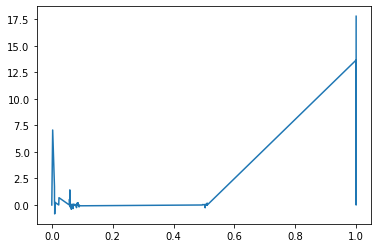

In [163]:
all = []
for url in testUserRepos['url']:
    split = url.split('/')
    user = split[-2]
    project = split[-1]
    key = (user, project)
    if key in reposToMetrics:
        metrics = reposToMetrics[key]
        deltas = deltasOf(metrics)
        all.extend(deltas.values())
        #all.extend(metrics.items())
    else:
        print('Repo unavailable: '+str(key))
all.sort(key = lambda tup: tup[0], reverse=True)
plotByLifecycle(all)

## Using chainmap to map from user commits to metrics

Another one of the tested approaches uses chainmaps over all repositories in order to quickly access data for one commit.

In [141]:
start = time.time()
chainMap = collections.ChainMap(*allMetrics)
end = time.time()
print('Total Time used: '+str(end - start))

Total Time used: 0.00019025802612304688


The chainmap can successfully be used to get metrics for a given commit (although this approach has later been discarded)

In [143]:
sha = next(iter(next(iter(allMetrics))))
print(chainMap.get(sha, default=None))

(1391951934, 17.90714285714286, '02328f470caaf73eb99264465385c57d70b0bb87', 368)


In [ ]:
all = []
for url in testUserRepos['url']:
    split = url.split('/')
    user = split[-2]
    project = split[-1]
    key = (user, project)
    if key in reposToMetrics:
        metrics = reposToMetrics[key]
        deltas = deltasOf(metrics)
        all.extend(deltas.values())
        #all.extend(metrics.items())
    else:
        print('Repo unavailable: '+str(key))
all.sort(key = lambda tup: tup[0], reverse=True)
plotByLifecycle(all)

Shortcomings however include that all data has to be in memory and that further working with is (e.g. joining with developer data) is quite tedious.

# Further Progress from this point

Much has happened between this point and the first iteration run (which marks the beginning of [RepoAnalysis](./RepoAnalysis.ipynb) notebook). Some developments also occured parallely. However, the results of this phase were mostly extracted to the [repoAnalysis](./repoAnalysis.py) module and later overridden, so there are not many cells left. For the sake of continuity and completeness, this chapter tries to recap the improvements made.

## Using a table as output format

After experimenting with multiple output formats, persisting result data to a table seemed the best choice. There are several reasons for that:
* Persistency: When data is on disk, it does not need to be in memory which is both more friendly to other users of the system and more safe, as the data is not lost when a notebook is restarted
* Querying: SQL is a perfect domain language for running analytic queries on the dataset
* Easy joins: The table allows to easily join the data with developer data or parent commit data which is very good

## Lab for new metrics

The set of available metrics shown before only consists of loc per method, loc in general, and lambda density. As this is quite a limited set of metrics, this section of the notebook was assigned for the development of new metrics.

As test code the following source was taken: (It includes nearly all possible combinations for comments and strings):

In [105]:
x = '''
/**
Cool javadoc that shows how cool the class is
*/
public class Foo extends Bar {//Hidden comment
    /**Documentation for a*/
    public static Object b = "//No, no comment";
    //Docu for b
    public String/*Mean inline comment*/ b;
    /* Another
    Multiline*/

    public static void main(String[] args) {
        //Comment
        //Comment
        System.out.println("Actual code goes here /*This is not a comment ...")
        System.out.println("... and it doesn't end here*/")

    }
}
'''

### String Literal Removal

String literals are problematic for regex-based metrics, as code inside it should not count towards them. Therefore, a regex to remove string literals (or replace them with a more harmless one to prevent invalid syntx) hat been developed:

In [106]:
stringRemover = re.compile(r"\".*?\"")

Demonstration:

In [107]:
print(stringRemover.sub("\"...\"", x))


/**
Cool javadoc that shows how cool the class is
*/
public class Foo extends Bar {//Hidden comment
    /**Documentation for a*/
    public static Object b = "...";
    //Docu for b
    public String/*Mean inline comment*/ b;
    /* Another
    Multiline*/

    public static void main(String[] args) {
        //Comment
        //Comment
        System.out.println("...")
        System.out.println("...")

    }
}



### Comment finder

Similarly challenging, for the same reasons, are comments. They are additionally interesting in order to determine the number of comment lines as a metric. Comments in Java can be oneline (which starts with `//` and always counts as one comment line because there can never be two in one line) or multiline (between `/*` and `*/`, which counts as many lines that there are in, so just split along line breaks).

In [110]:
commentRegex = re.compile(r"//.*?\n|/\*.*?\*/", re.S)

In order to work good, this regex needs to be combined with the string literal regex. Demonstration:

In [111]:
matches = commentRegex.findall(stringRemover.sub("\"...\"", x))
print(matches)
# Trailing newlines indicate that comment ends with the newline (indicating a oneline comment) and are therefore stripped
print(sum(map(lambda x: len(x.rstrip().split("\n")), matches)))

['/**\nCool javadoc that shows how cool the class is\n*/', '//Hidden comment\n', '/**Documentation for a*/', '//Docu for b\n', '/*Mean inline comment*/', '/* Another\n    Multiline*/', '//Comment\n', '//Comment\n']
11


### Indent

Another interesting metric to calculate is the average indent that code has: Firstly it can be an indicator for code complexity (more indent usually means deeper nesting. Secondly, Python has a special way of dealing with indent, which is a good motivation to analyze this aspect.

The tricky part about indent is that there are several ways of doing this: While tabs are unambiguous for all environments (opinion of the author), there are several different numbers of spaces that can be used instead. [This](https://blog.overops.com/tabs-vs-spaces-how-they-write-java-in-google-twitter-mozilla-and-pied-piper/) blog suggests that "the majority use spaces in different formations, *preferring 4 spaces* over 2". So 4 spaces are assumed as one tab. This might warp results for developers that only use two spaces, and be a confounding factor if the usage of two or four spaces changes between the experiment groups. However, less than [a quarter](https://ukupat.github.io/tabs-or-spaces/) actually use two spaces on github, and other factors such as IDE and workplace also influence the indent.

The following non-regex method counts the number of trailing whitespace of each row, counting tabs as four. We expect an average of 1, as there are five lines and five indents.

In [113]:
y = '''
    indent_1
	    indent_2
        indent_2
'''
indents = list(map(lambda line: len(line[:(len(line)-len(line.lstrip()))].replace('\t', '    ')) / 4, y.split('\n')))
avg = sum(indents)/len(indents)
print(avg)

1.0


### Further metrics

As additional metrics a reflection heuristic and snake case usage were added, as both were expected to potentially differ for the polyglot users. The underlying regexes can be found at the [repoAnalysis](./repoAnalysis.py) module. 

## Calculating absolute metrics instead of per loc

One major change that was done in the approach was to calculate all metrics as occurences first and then calculating loc separately. This is based on the insight that saving densities to table only leads to data loss while we can still efficiently calculate them afterward from the table

## Generalizing metric calculation on metric suites

The "state of the art" metric calculation function at that point in time, `averageMetricPerCommitForRepo`, did only accept one single metric function. Of course all the previously developed metrics should be applied to all commits. With regard to the fact that data has been planned to be put into a table, the new `calculateMetrics` function (a version of which can still be found in the [repoAnalysis](./repoAnalysis.py) module for historical purposes) returns data as pandas dataframe (which has proven to be efficient and intuitive). Metrics functions are called each with all of full, header-free, and string-and-comment-free file contents. This abolishes the need to calculate these for multiple metrics improving run time a bit.